detect_coverage.ipynb

Authors: Indu Panigrahi and Tom Bu
<br>

This notebook uses the updated text files generated by estimate_ground_plane.ipynb to generate an alert if the query image contains a snow-covered sidewalk.

In [ ]:
# Install Mask2Former
%cd /home/ipanigra/Documents/Mask2Former/mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

Imports

In [1]:
# common libraries
from mpl_toolkits import mplot3d
import pickle as pkl
from PIL import Image
import numpy as np
from scipy.spatial import transform
import os
import matplotlib.pyplot as plt
import cv2
import torch
from shapely.geometry import Polygon
import descartes
import glob
%matplotlib inline

# detectron2 imports
from mask2former import add_maskformer2_config
import detectron2
from detectron2.utils.visualizer import _PanopticPrediction
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("mapillary_vistas_panoptic_val")
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")

# other scripts
from utils import read_cameras, get_intrinsic, get_extrinsic, project_3d_points, filter_3d_points

In [2]:
'''
This class is a representation for a mask. We treat the mask as a "pseudo-polygon".
'''
class myPolygon:
    def __init__(self, mask, pts):
        self.mask = mask # the binary mask in the shape of the image
        self.pts = pts # the associated points (pixels are treated as points)
    
    def iogt(self, otherpoly):
        '''
        Given another polygon (myPolygon otherpoly), returns the proportion of this polygon that is covered by otherpoly in 2D image coordinates.
        '''
        if otherpoly is None:
            print('No polygon provided for comparison.')
            return 0
        other_mask = otherpoly.mask
        return np.sum(np.logical_and(self.mask, other_mask)) / np.sum(self.mask)
    
    def iogt_pts(self, otherpoly):
        '''
        Given another polygon (myPolygon otherpoly), returns the proportion of this polygon that is covered by otherpoly in 3D world coordinates.
        This method is not used in this implementation as we project the sidewalks into the query image. However, this method can be used when projecting the snow
        in the query image into world coordinates for a bird's-eye view visualization.
        '''
        if otherpoly is None:
            print('No polygon provided for comparison.')
            return 0
        else:
            other_mask = set(zip(otherpoly.pts[:,0],otherpoly.pts[:,1]))
            this_mask = set(zip(self.pts[:,0],self.pts[:,1]))
            both_mask = this_mask.intersection(other_mask)
            return len(both_mask) / len(this_mask)
        

def init_detector(thresh = 0.8):
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_maskformer2_config(cfg)
    # mapillary vistas + panoptic segmentation
    cfg.merge_from_file("configs/mapillary-vistas/panoptic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_300k.yaml")
    cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/mapillary_vistas/panoptic/maskformer2_swin_large_IN21k_384_bs16_300k/model_final_132c71.pkl'
    cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
    cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
    cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
    predictor = DefaultPredictor(cfg)
    return cfg, predictor


'''
Detects either sidewalk or snow  (depending on sidewalk, default is True) and returns the mask as a myPolygon list.
'''
def get_detection(cam_path, predictor, args, show_img = True, show_polygon = False, save_img = False, sidewalk=True):
    im = cv2.imread(cam_path)
    sem_seg = predictor(im)["sem_seg"].to('cpu')
    stuff_classes = MetadataCatalog.get(args.cfg.DATASETS.TRAIN[0]).stuff_classes

    stuff_instances = []
    # detect sidewalk
    if sidewalk:
        idx = stuff_classes.index('Sidewalk')
    # detect snow
    else:
        idx = stuff_classes.index('Snow')
        
    detection = (sem_seg.argmax(0)==idx)
    if detection.max() > 0:
        stuff_instances.append(detection)
    
    polygons = []
    if len(stuff_instances) != 0:
        pred_mask = stuff_instances[0].numpy().astype('uint8')
        # exclude sidewalks above and/or to the left of the midpoint of the image (i.e. on the other side of the road / far)
        if sidewalk:
            midpt_x = detection.shape[1] // 2
            midpt_y = detection.shape[0] // 2
            exclude_x = np.arange(midpt_x)
            exclude_y = np.arange(midpt_y)
            pred_mask[:,exclude_x] = 0
            pred_mask[exclude_y,:] = 0
            
        if pred_mask.max() > 0:
            polygons.append(myPolygon(pred_mask,np.ones((2,2))))
            # code for visualizing and saving binary masks, commented out for simplicity
#             cv2.imwrite(str(sidewalk)+'.jpg',pred_mask*255)
#             cv2.imshow(str(idx),pred_mask*255)
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()

    return polygons


def get_3d_points(path):
    """
    Parameters
    ----------
    path : str
        DESCRIPTION.

    Returns
    -------
    points3d : float16
        x, y, z, 3d ID of 3d points in the world frame.

    """
    # 3D point list with one line of data per point:
    #   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
    # TRACK[] is a list of images and their points which contain the 3D point
    path  = os.path.join(path, 'points3D.txt')
    points3d = np.loadtxt(path, usecols = (1, 2, 3, 0, 4, 5, 6))
    points3d = points3d[(points3d[:, 4] == 0) & (points3d[:, 5] == 255) & (points3d[:, 6] == 0), :4]
    return points3d


def read_image_points(path):
    """
    input: root path
    
    returns
    ---------
    imgto2dfeatures
        dictionaries of image file names to the 2D features 
    """     
    imgto2dfeatures = {}
    path  = os.path.join(path, 'images.txt')
    with open(path) as f:
        lines = f.read().splitlines()

    # Image list with two lines of data per image:
    #   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
    #   POINTS2D[] as (X, Y, POINT3D_ID)
    for i,line in enumerate(lines):
        if line[0] == '#':
            continue
        else:
            if i % 2 == 0:
                fields = line.split(' ')
                # NAME
                image_name = os.path.basename(fields[-1])
                # IMAGE_ID
                image_id = int(fields[0])                
            else:
                fields = line.split(' ')
                points_2d = np.array([float(pt) for pt in fields])
                points_2d = np.reshape(points_2d, (-1, 3))
                # maps the name to 2d points in the image
                imgto2dfeatures[image_id] = points_2d
    return imgto2dfeatures


def read_images(path):
    """
    input: root path
    returns: images: IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID
             names: list of image file names 
    """     
    path  = os.path.join(path, 'images.txt')
    images = np.loadtxt(path, usecols = (0, 1, 2, 3, 4, 5, 6, 7, 8))
    images = images[::2]
    names = np.loadtxt(path, usecols = (9), dtype='str')
    names = names[::2]
    names = names.tolist()
    
    return images, names


def get_projections(name, names, images, cameras, points, force_pinhole = True, show_img = False, cam_path = None):
    '''
    Obtains the points that are projected into the image. 
    Returns the pixel coordinates in the image frame as well as the 3D point ID.

    Parameters
    ----------
    name : str
        name of the image.
    names : list
        list of all images.
    images : array
        image pose array.
    cameras : array
        camera intrinsics array.
    force_pinhole : TYPE, optional
        if you want to force a pinhole camera model. The default is True.

    Returns
    -------
    pixel_full : array (n x 3)
        pixel coordinates of 3D point projections.
    id3d_full : array (n x 1)
        3D point IDs

    '''
    i = names.index(name)
    image = images[i]
    image_id = int(image[0])
    
    pose = image[1:8]
    cameraID = int(image[8])
    
    intrinsic = cameras[cameras[:, 8] == cameraID, :].flatten()
    
    #camera parameters
    extrinsic = get_extrinsic(pose)
    pixel_full, id3d_full = project_3d_points(points, extrinsic, intrinsic, force_pinhole = force_pinhole)
    
    if show_img:
        assert cam_path is not None
        im = cv2.imread(cam_path)

        plt.figure(num = 2)
        plt.scatter(pixel_full[:, 0], pixel_full[:, 1])
        plt.imshow(im[:, :, [2, 1, 0]])

    return pixel_full, id3d_full


def get_position(name, names, images):
    '''
    Obtains the location of the camera in x, y, z coordinates.
    
    Parameters
    ----------
    name : str
        name of the image.
    names : list
        list of all images.
    images : array
        image pose array.
        
    Returns
    -------
    position : array (3 x 1)
        3D location of the camera
    '''
    i = names.index(name)
    image = images[i]
    image_id = int(image[0])
    pose = image[1:8]
    
    q = pose[:4]
    # make scalar last
    q = q[[1, 2, 3, 0]]
    # get rotation matrix from the quaternion. world to cam
    R_w2c = transform.Rotation.from_quat(q)
    
    # world to cam translation
    t= pose[4:]
    
    position = - R_w2c.as_matrix().T.dot(t) 

    
    return position


def find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr):
    '''
    Returns the homography matrix that converts the ground plane of the current frome into the reference frame
    
    Parameters:
    pixel_ref : array (n x 3)
        pixel coordinates of 3D point projections.
    id3d_ref : array (n x 1)
        3D point IDs
    pixel_curr : array (n x 3)
        pixel coordinates of 3D point projections.
    id3d_curr : array (n x 1)
        3D point IDs
    '''
    _, idx_ref, idx_curr = np.intersect1d(id3d_ref.flatten(), id3d_curr.flatten(), return_indices=True)

    pixel_ref = pixel_ref[idx_ref, :]
    pixel_curr = pixel_curr[idx_curr, :] 
    if len(pixel_ref) >= 4 and len(pixel_curr) >= 4:
        M, status = cv2.findHomography(pixel_curr[:, :2], pixel_ref[:, :2], cv2.RANSAC)
        return M
    else:
        return None


def transform_points(curr_detection, M, cam_path = None, use_mask=True):
    '''
    Applies the homography matrix M to the detection (curr_detection).
    M is the homography from the image to the estimated ground plane (pixel to world coordinates).
    '''
    if M is None:
        "failed homography"
        return []
    polygons = []
    for poly in curr_detection:
        if use_mask:
            hull = np.argwhere(poly.mask)[:,[1,0]]
        else:
            hull = poly.pts

        hull = np.concatenate((hull, np.ones((hull.shape[0], 1))), axis = 1)
        hull = hull.T
        hull = M @ hull
        hull = hull.T
        hull = hull/hull[:, 2:3]
        points = [(p0, p1) for (p0, p1) in zip(hull[:, 0], hull[:, 1])]
        transformed_mask = np.zeros((720,1280))
        print('sample point', points[0])
        
        if use_mask:
            poly = myPolygon(poly.mask, np.array(points))
        else:
            poly = myPolygon(transformed_mask, np.array(points))
        polygons.append(poly)
        
    return polygons


def transform_points_toimage(curr_detection, M, cam_path = None):
    '''
    Applies the homography matrix M to the detection (curr_detection).
    M is the homography from the estimated ground plane to the image (world coordinates to pixel).
    '''
    if M is None:
        "failed homography"
        return []
    polygons = []
    for poly in curr_detection:
        hull = poly.pts
#         hull = np.array(poly.exterior.coords[:-1]) # makes 2D numpy array of x,y? coords, the -1 was for removing the repeated point
        hull = np.concatenate((hull, np.ones((hull.shape[0], 1))), axis = 1)
        hull = hull.T
        hull = M @ hull
        hull = hull.T
        hull = hull/hull[:, 2:3]
        points = [(p0, p1) for (p0, p1) in zip(hull[:, 0], hull[:, 1])]
        
        transformed_mask = np.zeros((720,1280))
        print('sample point', points[0])
        
        # filter off-image projections
        def filter_proj(p):
            return (p[0]>=0 and p[0]<1280) and (p[1]>=0 and p[1]<720)
        points = np.array(points)
        in_image = np.apply_along_axis(filter_proj, 1, points)
        points_in_img = points[in_image].astype(int)
        transformed_mask[points_in_img[:,1],points_in_img[:,0]] = 1
        
        poly = myPolygon(transformed_mask, np.array(points))
        polygons.append(poly)
    
    return polygons
    

def sum_dict(total, single):
    for key, value in single.items():
        total[key] = value + total.get(key, 0)
    
    return total


def fit_plane(data):
    A = np.ones((data.shape[0], 1))
    A = np.concatenate([data, A], axis = 1)
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    coef = vt[3, :]    
    return coef

In [ ]:
def reconstruct_sidewalks(parent, args, check_valid_distance = False):
    '''
    Saves sidewalk points from clear weather reference images.
    '''
    
    # get the ground plane points and camera poses for reference images
    points = get_3d_points(os.path.join(args.path, parent))
    points = points[::5, :]
    
    print('max points', np.amax(points))
    print('min points', np.amin(points))
    
    
    coef = fit_plane(points[:, :3])
    
    id3d_ref = points[:, 3:4]
    pixel_ref = points[:, 0:2]
    
    images, names = read_images(os.path.join(args.path, parent))
    cameras = read_cameras(os.path.join(args.path, parent), subdir = '')
    
    logs = {}
    logs['camera3'] = args.reference_imgs
   

    placeholder = np.array([[0,0]])
    with open(os.path.join(args.path,'saved_sidewalk_points'),'wb') as f:
        pkl.dump(placeholder, f)
    f.close()

    curr_log = 'camera3'
    # save sidewalk points from all reference images
    for curr_img in logs[curr_log]:
        # detect sidewalk
        print('IMAGE NAME:', curr_img)
        curr_path = os.path.join(args.img_path, 'clear_references', curr_img)
        curr_detection = get_detection(cam_path = curr_path, predictor = args.predictor, show_img = False, save_img = args.save_pred, args = args)
        
        # project 2D detection into world coordinates of point cloud
        pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)
        M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
        curr3d_detection = transform_points(curr_detection, M, None)
        
        # append sidewalk points from current reference image to existing points
        with open(os.path.join(args.path,'saved_sidewalk_points'),'rb') as f:
            sidewalk_pts = pkl.load(f)
        f.close()
        new_sidewalk_pts = np.append(sidewalk_pts, np.array(curr3d_detection[0].pts),axis=0) if (len(curr3d_detection) > 0) else sidewalk_pts
        with open(os.path.join(args.path,'saved_sidewalk_points'),'wb') as f:
            pkl.dump(new_sidewalk_pts, f)
        f.close()
        
        
def classify_query(parent, args, check_valid_distance = False):
    '''
    Detects snow coverage on sidewalks.
    '''
    
    # get the ground plane points and camera poses for reference images
    points = get_3d_points(os.path.join(args.path, parent))
    points = points[::5, :]
    
    print('max points', np.amax(points))
    print('min points', np.amin(points))
    
    
    coef = fit_plane(points[:, :3])
    
    id3d_ref = points[:, 3:4]
    pixel_ref = points[:, 0:2]
    
    images, names = read_images(os.path.join(args.path, parent))
    cameras = read_cameras(os.path.join(args.path, parent), subdir = '')
    
    logs = {}
    logs['query_img'] = [args.query]
   
    log_poly = {}
    curr_log = 'query_img'
    for curr_img in logs[curr_log]:
        # detect snow
        curr_path = os.path.join(args.img_path, 'query', curr_img)
        print('IMAGE NAME', curr_img)
        curr_detection = get_detection(cam_path = curr_path, predictor = args.predictor, show_img = False, save_img = args.save_pred, args = args, sidewalk=False)

        pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)
        M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
        curr3d_detection = transform_points(curr_detection, M, None, False)

        log_poly[curr_log] = curr3d_detection
        
        # project saved sidewalk points into the query image
        for curr_img in logs[curr_log]:
            curr_path = os.path.join(args.img_path, 'query', curr_img)
            pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)

            inv_M = find_homography(id3d_curr, pixel_curr, id3d_ref, pixel_ref)
            # code when projecting saved sidewalk points into 3D world coordinates for bird's-eye view, comment out previous line
            # M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)

            with open(os.path.join(args.path,'saved_sidewalk_points'),'rb') as f:
                sidewalk_pts = pkl.load(f)
            f.close()
            curr_detection = [myPolygon(None, sidewalk_pts[1:,:])]
            
            curr3d_detection = transform_points_toimage(curr_detection, inv_M, None, False)
            # code when projecting saved sidewalk points into 3D world coordinates for bird's-eye view, comment out previous line
            # curr3d_detection = transform_points(curr3d_detection, M, None, False, use_mask=False)

            log_poly['camera3'] = curr3d_detection
    

    # check if sidewalk is covered with snow
    ref_log = 'camera3'
    ref_detection = log_poly[ref_log] # sidewalks
    curr_detection = log_poly[curr_log] # snow

    covered = []
    clear = []    
    for gt_poly in ref_detection:
        seen = False
        for pred_poly in curr_detection:
            curr_iogt = gt_poly.iogt(pred_poly)
            print('Proportion of sidewalk covered:', curr_iogt)
            
            alert_threshold = 0.6
            if seen:
                continue
            if curr_iogt > alert_threshold:
                seen = True
                covered.append(gt_poly)
            else:
                print('Bird\'s-eye view:')
                fig, ax = plt.subplots(1, 3, figsize=(15,7))
                # sidewalk and snow
                ax[0].scatter(points[:,0], points[:,1], c='gray')
                ax[0].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
                ax[0].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue',s = 0.01)
                # sidewalk
                ax[1].scatter(points[:,0], points[:,1], c='gray')
                ax[1].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
                # snow
                ax[2].scatter(points[:,0], points[:,1], c='gray')
                ax[2].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue', s=0.01)
                plt.show()
#                 plt.savefig(os.path.join(args.path, parent, 'bev.jpg'))
            
            ### begin save visualization ###
            sidewalk = gt_poly.mask
            snow = pred_poly.mask
            im = np.array(Image.open(os.path.join(args.img_path, 'query', curr_img)))
            
            sidewalk_array = np.zeros((720,1280,3))
            for c in range(3):
                sidewalk_array[:,:,c] = sidewalk
                
            snow_array = np.zeros((720,1280,3))
            for c in range(3):
                snow_array[:,:,c] = snow
                
            sidewalk_px = np.logical_and(np.logical_xor(sidewalk_array, snow_array), sidewalk_array)*1
            snow_px = snow_array.astype(int)
            im_px = np.logical_not(np.logical_or(sidewalk_px, snow_px))*1
            
            sidewalk_px[:,:,2]*=249 #255
            sidewalk_px[:,:,1]*=215 #213
            sidewalk_px[:,:,0]*=28 #139

            snow_px[:,:,2]*=0
            snow_px[:,:,1]*=50
            snow_px[:,:,0]*=200

            im_px[:,:,2]*=im[:,:,0]
            im_px[:,:,1]*=im[:,:,1]
            im_px[:,:,0]*=im[:,:,2]
            
            im_px_removed = np.logical_or(sidewalk_px, snow_px)*1
            im_px_removed[:,:,2]*=im[:,:,0]
            im_px_removed[:,:,1]*=im[:,:,1]
            im_px_removed[:,:,0]*=im[:,:,2]
            
            res = cv2.addWeighted(im_px_removed, 0.75, snow_px+sidewalk_px, 0.25, 1.0)
            plt.imshow(res+im_px) # color will appear inverted
            cv2.imwrite('results.jpg',res+im_px)
            ### end save visualization ###

        if seen == False:
            clear.append(gt_poly)
        
    if len(covered) > 0:
        return 1 # sidewalk is covered with snow, generate alert
    else:
        return 0

class Argument:
    def __init__(self, path, out_path, img_path, debug, save_pred, removal):
        self.path = path
        self.out_path = out_path
        self.img_path = img_path
        self.debug = debug
        self.save_pred = save_pred
        self.removal = removal

def detect_coverage(reference_imgs, query, path, out_path, img_path, modelpath, debug = False, save_pred = False, multi_image = False, removal = False, threshold = 0.95):
    args = Argument(path, out_path, img_path, debug, save_pred, removal)
    cfg,predictor = init_detector(thresh=threshold) 
    args.predictor = predictor
    args.multi_image = multi_image
    args.cfg = cfg
    args.reference_imgs = reference_imgs
    args.query = query

    reconstruct_sidewalks('', args)
    alert = classify_query('', args)
    if alert:
        print('Snow-covered sidewalk detected.')
    else:
        print('Clear sidewalk.')
        
    return alert

Detect snow-covered sidewalk

Loading config configs/mapillary-vistas/panoptic-segmentation/swin/../Base-MapillaryVistas-PanopticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
/home/ipanigra/Documents/riss2022/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


WARNING [08/23 00:51:46 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...
max points 999943.0
min points -7.82704174125626
IMAGE NAME camera3_1641584745_444211265.jpg


/home/ipanigra/Documents/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/ipanigra/Documents/Mask2Former/mask2former/maskformer_model.py:355: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
 

sample point (1.2551771036634358, -10.997241535927525)
proportion 0.005575960898863406
sample point (774.6971475764619, 90.71512528342657)
sample point (774.6971475764619, 90.71512528342657)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoGT 0.4388289850701252
Debug


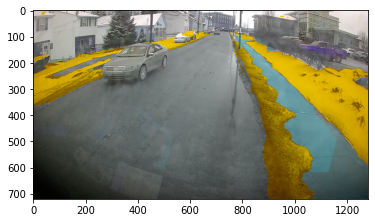

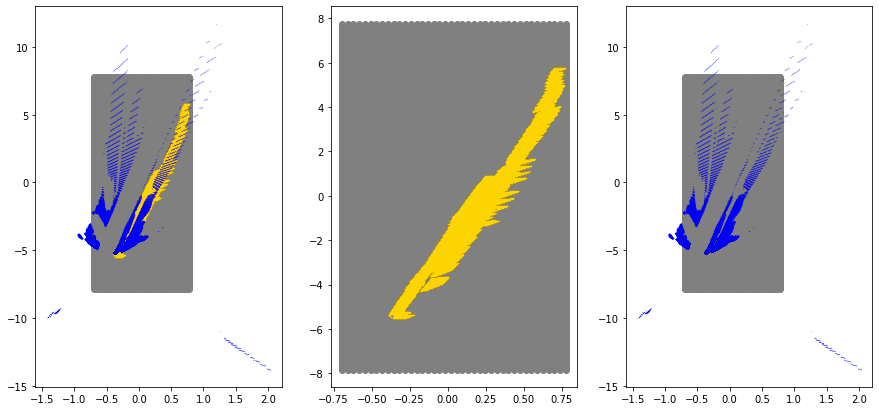

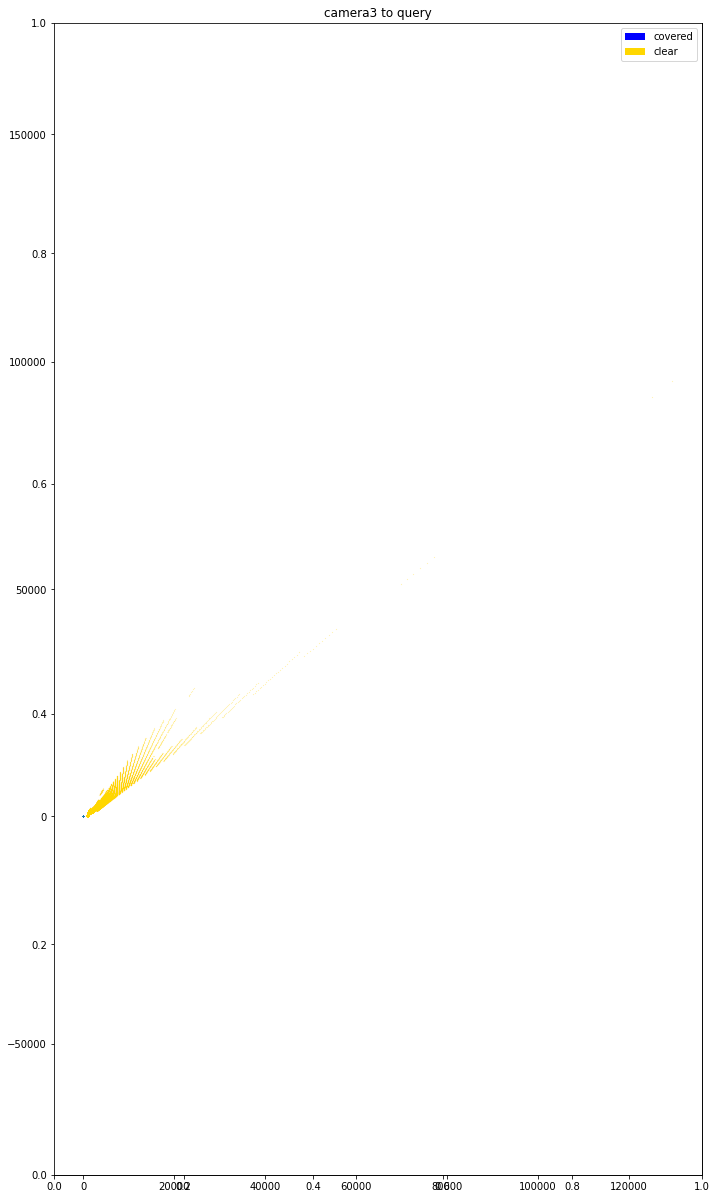

COUNT CORRECT = 1
TOTAL = 170


In [ ]:
path = './output_onequery'
img_path = './img_coverage'
out_path = './out_coverage'

# get reference image names
clear_imgs = glob.glob('img_coverage/clear_references/*')
used_for_reconstruction = read_images(path)[1]
# remove prepended directory information
reference_imgs = []
for i in clear_imgs:
    curr_img = i.split('/')[2]
    if (curr_img != 'camera3_1641584745_444211265.jpg') and (curr_img in used_for_reconstruction):
        reference_imgs.append(curr_img)

# get query image name
query = glob.glob('img_coverage/query/*').split('/')[2]

# check if query contains a snow-covered sidewalk
detect_coverage(reference_imgs, query, path, out_path, img_path, '')

In [ ]:
def classify_query(parent, args, check_valid_distance = False):
    '''
    Detects snow coverage on sidewalks.
    '''
    
    # get the ground plane points and camera poses for reference images
    points = get_3d_points(os.path.join(args.path, parent))
    points = points[::5, :]
    
    print('max points', np.amax(points))
    print('min points', np.amin(points))
    
    
    coef = fit_plane(points[:, :3])
    
    id3d_ref = points[:, 3:4]
    pixel_ref = points[:, 0:2]
    
    images, names = read_images(os.path.join(args.path, parent))
    cameras = read_cameras(os.path.join(args.path, parent), subdir = '')
    
    logs = {}
    logs['query_img'] = [args.curr_img]
   
    log_poly = {}
    curr_log = 'query_img'
    for curr_img in logs[curr_log]:
        # detect snow
        curr_path = os.path.join(args.img_path, 'query', curr_img)
        print('IMAGE NAME', curr_img)
        curr_detection = get_detection(cam_path = curr_path, predictor = args.predictor, show_img = False, save_img = args.save_pred, args = args, sidewalk=False)

        pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)
        M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
        curr3d_detection = transform_points(curr_detection, M, None, False)

        log_poly[curr_log] = curr3d_detection
        
        # project saved sidewalk points into the query image
        for curr_img in logs[curr_log]:
            curr_path = os.path.join(args.img_path, 'query', curr_img)
            pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)

            inv_M = find_homography(id3d_curr, pixel_curr, id3d_ref, pixel_ref)
            # code when projecting saved sidewalk points into 3D world coordinates for bird's-eye view, comment out previous line
            # M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)

            with open(os.path.join(args.path,'saved_sidewalk_points'),'rb') as f:
                sidewalk_pts = pkl.load(f)
            f.close()
            curr_detection = [myPolygon(None, sidewalk_pts[1:,:])]
            
            curr3d_detection = transform_points_toimage(curr_detection, inv_M, None, False)
            # code when projecting saved sidewalk points into 3D world coordinates for bird's-eye view, comment out previous line
            # curr3d_detection = transform_points(curr3d_detection, M, None, False, use_mask=False)

            log_poly['camera3'] = curr3d_detection
    

    # check if sidewalk is covered with snow
    ref_log = 'camera3'
    ref_detection = log_poly[ref_log] # sidewalks
    curr_detection = log_poly[curr_log] # snow

    covered = []
    clear = []    
    for gt_poly in ref_detection:
        seen = False
        for pred_poly in curr_detection:
            curr_iogt = gt_poly.iogt(pred_poly)
            print('Proportion of sidewalk covered:', curr_iogt)
            
            alert_threshold = 0.6
            if seen:
                continue
            if curr_iogt > alert_threshold:
                seen = True
                covered.append(gt_poly)
            else:
                print('Bird\'s-eye view:')
                fig, ax = plt.subplots(1, 3, figsize=(15,7))
                # sidewalk and snow
                ax[0].scatter(points[:,0], points[:,1], c='gray')
                ax[0].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
                ax[0].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue',s = 0.01)
                # sidewalk
                ax[1].scatter(points[:,0], points[:,1], c='gray')
                ax[1].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
                # snow
                ax[2].scatter(points[:,0], points[:,1], c='gray')
                ax[2].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue', s=0.01)
                plt.show()
#                 plt.savefig(os.path.join(args.path, parent, 'bev.jpg'))
            
            ### begin save visualization ###
            sidewalk = gt_poly.mask
            snow = pred_poly.mask
            im = np.array(Image.open(os.path.join(args.img_path, 'query', curr_img)))
            
            sidewalk_array = np.zeros((720,1280,3))
            for c in range(3):
                sidewalk_array[:,:,c] = sidewalk
                
            snow_array = np.zeros((720,1280,3))
            for c in range(3):
                snow_array[:,:,c] = snow
                
            sidewalk_px = np.logical_and(np.logical_xor(sidewalk_array, snow_array), sidewalk_array)*1
            snow_px = snow_array.astype(int)
            im_px = np.logical_not(np.logical_or(sidewalk_px, snow_px))*1
            
            sidewalk_px[:,:,2]*=249 #255
            sidewalk_px[:,:,1]*=215 #213
            sidewalk_px[:,:,0]*=28 #139

            snow_px[:,:,2]*=0
            snow_px[:,:,1]*=50
            snow_px[:,:,0]*=200

            im_px[:,:,2]*=im[:,:,0]
            im_px[:,:,1]*=im[:,:,1]
            im_px[:,:,0]*=im[:,:,2]
            
            im_px_removed = np.logical_or(sidewalk_px, snow_px)*1
            im_px_removed[:,:,2]*=im[:,:,0]
            im_px_removed[:,:,1]*=im[:,:,1]
            im_px_removed[:,:,0]*=im[:,:,2]
            
            res = cv2.addWeighted(im_px_removed, 0.75, snow_px+sidewalk_px, 0.25, 1.0)
            plt.imshow(res+im_px) # color will appear inverted
            cv2.imwrite('results.jpg',res+im_px)
            ### end save visualization ###

        if seen == False:
            clear.append(gt_poly)
        
    if len(covered) > 0:
        return 1 # sidewalk is covered with snow, generate alert
    else:
        return 0

In [ ]:
def detect_coverage(parent, args, check_valid_distance = False):
    '''
    Detects snow coverage on sidewalks.
    '''
    
    # get the ground plane points and camera poses for reference images
    points = get_3d_points(os.path.join(args.path, parent))
    points = points[::5, :]
    
    print('max points', np.amax(points))
    print('min points', np.amin(points))
    
    
    coef = fit_plane(points[:, :3])
    
    id3d_ref = points[:, 3:4]
    pixel_ref = points[:, 0:2]
    
    images, names = read_images(os.path.join(args.path, parent))
    cameras = read_cameras(os.path.join(args.path, parent), subdir = '')
    
    logs = {}
    logs['query_img'] = [args.curr_img]
    logs['camera3'] = [args.curr_img]
    change_logs = logs
   
    ############## save the sidewalk points in the scene ############### 
    placeholder = np.array([[0,0]])
    with open(os.path.join(path,'saved_sidewalk_points'),'wb') as f:
        pkl.dump(placeholder, f)
    f.close()

    if args.debug:
        track_det = []
    log_poly = {}
    change_logs = ['query_img', 'camera3']
    curr_log = 'query_img'
    for curr_img in logs[curr_log]:
        # detect snow
        curr_path = os.path.join(args.img_path, 'one_query', curr_img)
        print('IMAGE NAME', curr_img)
        curr_detection = get_detection(cam_path = curr_path, predictor = args.predictor, show_img = False, save_img = args.save_pred, args = args, sidewalk=False)

        pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)
        M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
        curr3d_detection = transform_points(curr_detection, M, None, False)

        log_poly[curr_log] = curr3d_detection
        
        # begin query-only section
        for curr_img in logs['camera3']:
            curr_path = os.path.join(args.img_path, 'one_query', curr_img)
            pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)

            # project saved sidewalk points
            M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
            inv_M = find_homography(id3d_curr, pixel_curr, id3d_ref, pixel_ref)

            with open(os.path.join(args.path,'sidewalks_onequery'),'rb') as f:
                sidewalk_pts = pkl.load(f)
            f.close()

            curr_detection = [myPolygon(None, sidewalk_pts[1:,:])]
            # filter saved sidewalk points
            curr3d_detection = transform_points_toimage(curr_detection, inv_M, None, False)
            # project saved sidewalk points or could just compare masks
#             curr3d_detection = transform_points(curr3d_detection, M, None, False, use_mask=False)

#             plt.title('Debug')
#             plt.scatter(pixel_ref[:,0], pixel_ref[:,1], c='blue')
#             plt.scatter(curr3d_detection[0].pts[:,0], curr3d_detection[0].pts[:,1], c='red')
#             plt.show()
            log_poly['camera3'] = curr3d_detection
    

    ############### perform change detection ##################
    
    curr_log = 'query_img'
    ref_log = 'camera3'
    ref_detection = log_poly[ref_log]
    curr_detection = log_poly[curr_log]

    # check if sidewalk is covered in snow
    covered = []
    clear = []    
    for gt_poly in ref_detection:
        seen = False
        for pred_poly in curr_detection:
            curr_iogt = gt_poly.iogt(pred_poly)
            print('IoGT', curr_iogt)
            
            ### save image ###
            sidewalk = gt_poly.mask
            snow = pred_poly.mask
            im = np.array(Image.open(os.path.join(args.img_path, 'one_query', curr_img)))
            
            sidewalk_array = np.zeros((720,1280,3))
            for c in range(3):
                sidewalk_array[:,:,c] = sidewalk
                
            snow_array = np.zeros((720,1280,3))
            for c in range(3):
                snow_array[:,:,c] = snow
                
            sidewalk_px = np.logical_and(np.logical_xor(sidewalk_array, snow_array), sidewalk_array)*1
            snow_px = snow_array.astype(int)
            im_px = np.logical_not(np.logical_or(sidewalk_px, snow_px))*1
            
            sidewalk_px[:,:,2]*=249 #255
            sidewalk_px[:,:,1]*=215 #213
            sidewalk_px[:,:,0]*=28 #139

#             snow_px[:,:,2]*=141
#             snow_px[:,:,1]*=186
#             snow_px[:,:,0]*=206
            snow_px[:,:,2]*=0
            snow_px[:,:,1]*=50
            snow_px[:,:,0]*=200

            im_px[:,:,2]*=im[:,:,0]
            im_px[:,:,1]*=im[:,:,1]
            im_px[:,:,0]*=im[:,:,2]
            
            im_px_removed = np.logical_or(sidewalk_px, snow_px)*1
            im_px_removed[:,:,2]*=im[:,:,0]
            im_px_removed[:,:,1]*=im[:,:,1]
            im_px_removed[:,:,0]*=im[:,:,2]
            
            res = cv2.addWeighted(im_px_removed, 0.75, snow_px+sidewalk_px, 0.25, 1.0)
#             res = cv2.addWeighted(res, 0.5, sidewalk_px, 0.5, 1.0)
            
#             plt.imshow(sidewalk_px+snow_px+im_px) 
            plt.imshow(res+im_px)
#             cv2.imwrite('results.jpg',sidewalk_px+snow_px+im_px)
#             cv2.imwrite('results.jpg',res+im_px)
            ### end save image ###
            
            if seen:
                continue
            if curr_iogt > 0.5:
                seen = True
                covered.append(gt_poly)
            else:
                print('Debug')
#                 fig = plt.figure()
#                 ax = plt.axes(projection='3d')
#                 ax.scatter3D(points[:,0], points[:,1], points[:,2], c='gray');
#                 ax.scatter3D(gt_poly.pts[:,0], gt_poly.pts[:,1], gt_poly.pts[:,2], c='gold');
#                 ax.scatter3D(pred_poly.pts[:,0], pred_poly.pts[:,1], pred_poly.pts[:,2], c='blue');
#                 plt.show()
#                 with open(os.path.join(args.path,'sidewalks'),'rb') as f:
#                     sidewalk_pts = pkl.load(f)
#                 f.close()
                fig, ax = plt.subplots(1, 3, figsize=(15,7))
                ax[0].scatter(points[:,0], points[:,1], c='gray')
                ax[0].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
#                 ax[0].scatter(gt_poly.pts[:,0], gt_poly.pts[:,1], c='gold',s = 0.01)
                ax[0].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue',s = 0.01)
                # sidewalk
                ax[1].scatter(points[:,0], points[:,1], c='gray')
#                 ax[1].scatter(gt_poly.pts[:,0], gt_poly.pts[:,1], c='gold', s=0.01)ii
                ax[1].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
                # snow
                ax[2].scatter(points[:,0], points[:,1], c='gray')
                ax[2].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue', s=0.01)
#                 plt.setp(ax, xlim=(-1,1), ylim=(-10,10))
                plt.show()
#                 plt.savefig(os.path.join(args.path, parent, 'bev.jpg'))
        if seen == False:
            clear.append(gt_poly)

    # visualize change
    from matplotlib.patches import Patch
    fig = plt.figure(figsize=(9, 16))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title('{} to {}'.format(ref_log.split('_')[0], curr_log.split('_')[0]))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('equal')
    ax.scatter(points[:, 0], points[:, 1], s = 0.01)
    for poly in clear:
#         pts = np.argwhere(poly.mask)[:,[1,0]]
        with open(os.path.join(args.path,'sidewalks_onequery'),'rb') as f:
            sidewalk_pts = pkl.load(f)
        f.close()
#         ax.scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='green',s = 0.01)
        ax.scatter(poly.pts[:,0], poly.pts[:,1], s = 0.01, c='gold')
#         ax.add_patch(descartes.PolygonPatch(poly, fc = 'g'))
    for poly in covered:
#         ax.add_patch(descartes.PolygonPatch(poly, fc = 'b'))
#         pts = np.argwhere(poly.mask)[:,[1,0]]
        ax.scatter(poly.pts[:,0], poly.pts[:,1], s = 10, c='b')        
    r = Patch(facecolor='b', label='covered')
    g = Patch(facecolor='gold', label='clear')
    ax.legend(handles=[r, g])
    plt.show()

#     plt.savefig(os.path.join(args.path, parent, 'change.jpg'))

    
    #save another figure to show the difference between the detections 
#     for poly in ref_detection:
#         ax.add_patch(descartes.PolygonPatch(poly, fc = 'y'))        
#     for poly in curr_detection:
#         ax.add_patch(descartes.PolygonPatch(poly, fc = 'm'))                  
#     m = Patch(facecolor='m', label='query')
#     y = Patch(facecolor='y', label='ref')
#     if args.removal:
#         ax.legend(handles=[r, g, m, y])
#     else:
#         ax.legend(handles=[r, g, m, y])
    
#     plt.savefig(os.path.join(args.path, parent, 'change_debug.jpg'))
    
    # plt.show()
    if len(covered) > 0:
        return 1, None
    else:
        return 0, None
    # end query-only section
    
    return 0, None